# CZ4042 Neural Networks & Deep Learning
## Assignment - 1: Part B, Question 2

> Gupta Jay  
> U1822549K  
> School of Computer Science and Engineering  
> Nanyang Technological University, Singapore  

## Imports

In [1]:
# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import StringLookup
from tensorflow.keras.layers import Embedding, Reshape
from tensorflow.keras.metrics import RootMeanSquaredError
import pandas as pd
from tensorflow.keras import backend as K
from matplotlib import pyplot as plt

In [3]:
print(tf.__version__)

2.6.0


In [4]:
# Supress any warnings for clean presentation
import warnings
warnings.filterwarnings("ignore")

In [5]:
df = pd.read_csv('hdb_price_prediction.csv')
df.head()

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0


## Preparing for Embedding Layer

To encode categorial features, the `output_mode` of the Lookup class is set to `int`. The `embedding layers` take the output of these encoded variables as inputs.

In [6]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="int") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


In [7]:
# Split data
train_dataframe = df[df['year'] <= 2020]
val_dataframe = df[df['year'] > 2020]

# Generate tf.data.Dataset objects for each dataframe
train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

# Batch the datasets
train_ds = train_ds.batch(128)
val_ds = val_ds.batch(128)

2021-10-14 14:48:23.431372: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# Categorical features (integers)
month = keras.Input(shape=(1,), name="month", dtype="int64")

# Categorical features encoded (integers)
month_encoded = encode_categorical_feature(month, "month", train_ds, False)

# Categorical feature (String)
flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")

# Categorical feature encoded (String)
flat_model_type_encoded = encode_categorical_feature(flat_model_type, "flat_model_type", train_ds, True)
storey_range_encoded = encode_categorical_feature(storey_range, "storey_range", train_ds, True)

# Numerical features
dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")

# Numerical Features Encoded
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)
remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)

# Combining all inputs
all_inputs = [
    month,
    flat_model_type,
    storey_range,
    dist_to_nearest_stn,
    dist_to_dhoby,
    degree_centrality,
    eigenvector_centrality,
    remaining_lease_years,
    floor_area_sqm
]

2021-10-14 14:48:23.706942: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


## Part A and Parb B: Adding an Embedding Layer

In [9]:
embedding_layers = []

# All Categorial Variables
categorial_variables = ["month", "flat_model_type", "storey_range"]

# All Categorial Variables (encoded)
categorial_variables_encoded = [month_encoded, flat_model_type_encoded, storey_range_encoded]

# Generate an embedding for each categorial variable and store it
for categorial_variable, categorial_variable_encoded in zip(categorial_variables, categorial_variables_encoded):
    # Output dimensions specified in the assignment manual
    unique_categories  = train_dataframe[categorial_variable].nunique()
    embedding_size = np.floor((unique_categories)/2)
    embedding_size = int(embedding_size)

    # Input Dimensions
    vocab  = unique_categories + 1
    
    # Embedding Layer
    embedding = Embedding(input_dim = vocab, output_dim = embedding_size)(categorial_variable_encoded)

    # Reshaping such that it can be concatenated
    embedding = Reshape((-1,))(embedding)
    embedding_layers.append(embedding)

In [10]:
# Combining all Encoded inputs
all_features = layers.concatenate(
    [
        embedding_layers[0],
        embedding_layers[1],
        embedding_layers[2],
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        remaining_lease_years_encoded,
        floor_area_sqm_encoded,
    ]
)

### R2 Value Metric

In [11]:
def coeff_determination(y_true, y_pred):
    # Custom Metric to calculate R2 Value
    # Source: https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
    SS_res =  K.sum(K.square(y_true-y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res/(SS_tot + K.epsilon()))

### 2-layer Feedforward Neural Network

In [12]:
def getModel(features, first_layer_activation, second_layer_activation):
    # Inputs -> Encoded Features (Concatenated) -> Dense -> Dense (Output)
    x = layers.Dense(10, activation=first_layer_activation)(features)
    output = layers.Dense(1, activation=second_layer_activation)(x)
    model = keras.Model(all_inputs, output)
    return model

def getOptimizer(lr):
    # Adam Optimizer (Default Parameters) -> Stochastic Gradient Descent
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    return optimizer

### Model Training

* **Loss Function**: Mean Squared Error
* **Learning Rate**: 0.05
* **Epochs**: 100
* **Batch Size**: 128 

In [13]:
loss = "mse"
metrics = [RootMeanSquaredError(), coeff_determination]
optimizer = getOptimizer(0.05)

model = getModel(all_features, "relu", "linear")
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

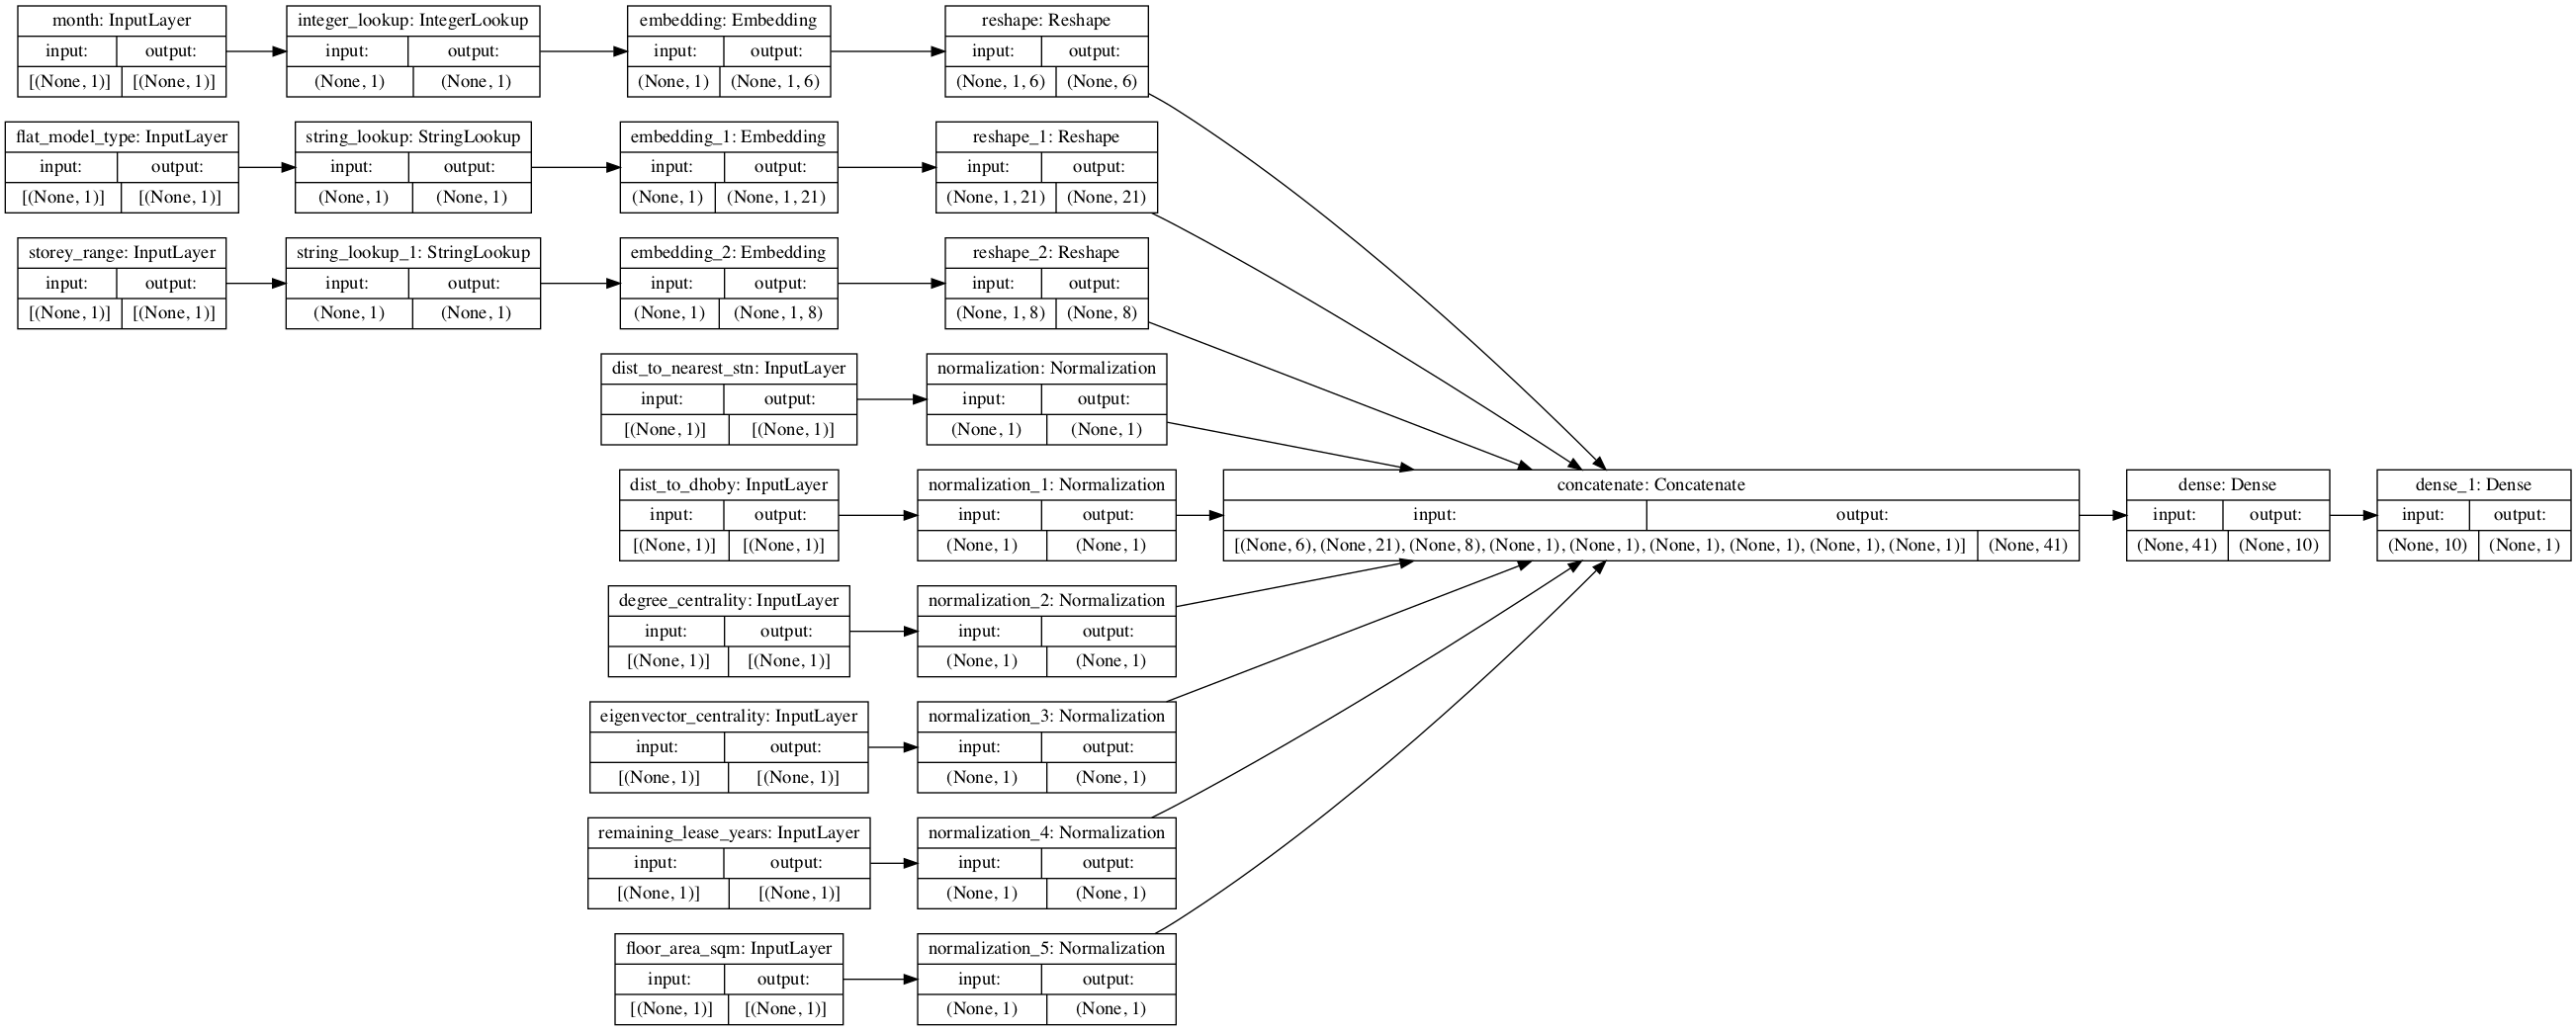

In [14]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [15]:
epochs = 100
verbose = 1
batch_size = 128

history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=verbose, batch_size=batch_size)

Epoch 1/100
683/683 [==============================] - 4s 4ms/step - loss: 48933765120.0000 - root_mean_squared_error: 221209.7812 - coeff_determination: -1.0547 - val_loss: 12630631424.0000 - val_root_mean_squared_error: 112386.0781 - val_coeff_determination: 0.5132
Epoch 2/100
683/683 [==============================] - 3s 3ms/step - loss: 8245698560.0000 - root_mean_squared_error: 90805.8281 - coeff_determination: 0.6486 - val_loss: 10499447808.0000 - val_root_mean_squared_error: 102466.8125 - val_coeff_determination: 0.5936
Epoch 3/100
683/683 [==============================] - 3s 3ms/step - loss: 7232543744.0000 - root_mean_squared_error: 85044.3672 - coeff_determination: 0.6911 - val_loss: 9285679104.0000 - val_root_mean_squared_error: 96362.2266 - val_coeff_determination: 0.6393
Epoch 4/100
683/683 [==============================] - 3s 3ms/step - loss: 6520332288.0000 - root_mean_squared_error: 80748.5781 - coeff_determination: 0.7214 - val_loss: 8084582400.0000 - val_root_mean_s

## Part E: Epoch with Lowest Test Error

In [16]:
# Extracting Train & Test RMSE from model history
val_rmse = history.history['val_root_mean_squared_error']
val_r2 = history.history['val_coeff_determination']

# Getting the epoch with the lowest RMSE
index_min = np.argmin(val_rmse) 

# Printing
print("----------------------------")
print("Epoch: " + str(index_min+1) + "th Epoch")
print("Root Mean Squared Error: %0.3f" % val_rmse[index_min])
print("R2 (Coefficient of Determination): %0.3f" % val_r2[index_min])
print("----------------------------")

----------------------------
Epoch: 98th Epoch
Root Mean Squared Error: 67943.734
R2 (Coefficient of Determination): 0.819
----------------------------


**Model from Q1 without Embedding Layers**
* **Epoch**: 70th Epoch
* **Root Mean Squared Error**: 69803.242
* **R2 (Coefficient of Determination)**: 0.809


**Model from Q2 with Embedding Layers**
* **Epoch**: 98th Epoch
* **Root Mean Squared Error**: 67943.734
* **R2 (Coefficient of Determination)**: 0.819

It is observed that the model with Embedding layers for categorical variables has lower RMSE and higher R2 which indicates that it has better performance. 

**Explanation:** `One-Hot` encoded vectors are very high dimensional (e.g. the length of the vector is as long as the number of unique values in a feature) which makes the representation very sparse. `Embedding layers` turns positive integers (indexes) into dense vectors of fixed size. These dense vectors represent the feature into a continuous vector space which helps the model due to the richer representation and find meaningful connections and relationships between the different values. As a result, the model is able to perform better, as demonstrated in this case. 

In conclusion, an `embedding layer` will translate a high dimensional sparse space into a relatively low-dimensional space which it easier for our neural network to learn from the data. Furthermore, embeddings allow us to capture spatial similarity of data by placing vectors closer that have similar meanings. For e.g. the vector for words (`Apple` and `Orange`) will be closer together, and farther from (`Dog` and `Cat`) since Apples and Oranges are fruits, whereas Dogs and Cats are animals.  

## End of Part B, Q2.